<h1 style="color:teal;text-align:center">Microsoft Malware Detection</h1>

## Data source

<p>    Microsoft has been very active in building anti-malware products over the years  and it runs it’s anti-malware utilities over <b>150 million computers</b> around the world. This generates tens of millions of daily data points to be analyzed as potential malware. In order to be effective in analyzing and classifying such large amounts of data, we need to be able to group them into groups and identify their respective families. 
<br>
<br>
This dataset provided by Microsoft contains about 9 classes of malware.
,</p>
<p>
 <a href=https://www.kaggle.com/c/malware-classification>Data Source</a>
</p>
<h4> Types of malware classes</h4>
<ol>
<li>Ramnit</li>
<li>Lollipop</li>
<li>Kelihos_ver3</li>
<li>Vundo</li>
<li>Simda</li>
<li>Tracur</li>
<li>Kelihos_ver1</li>
<li>Obfuscator.ACY</li>
<li>Gatak</li>
</ol>

There are 5 files in total, among which 2 are csv and 3 are .7z file. The size of all these sum upto ~38GB.

After extracting these file occupy a size of <b>200+ GB</b>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import codecs
import imageio
import array
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.sparse as sp
from datetime import datetime 
from itertools import product
import gc
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# DOWNLOAD DATA FROM KAGGLE
# UPLOAD YOUR KAGGLE TOKEN TO DOWNLOAD DATASET
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c 'malware-classification'

In [ ]:
# Keep only train.7z, trainLables files remove other files as shown below
!rm test.7z
!rm sampleSubmission.csv.zip
!rm dataSample.7z

In [ ]:
data=!7z l train.7z
print(len(data))
print(type(data))

In [ ]:
byte_file_list=[]
asm_file_list=[]
for i in data:
  if (i.endswith("bytes")):
    byte_file_list.append(i)
  elif (i.endswith("asm")):
    asm_file_list.append(i)

In [ ]:
#To download all the byte files from train.7z and below code will take almost 15mins.
if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/csvs'):
    start=datetime.now()

    !7z e train.7z -o/content/byteFiles *.bytes -r

    end=datetime.now()
    difference=end-start
    print('Time taken to extract all the byte files',difference)

## Distribution of malware classes in whole data set

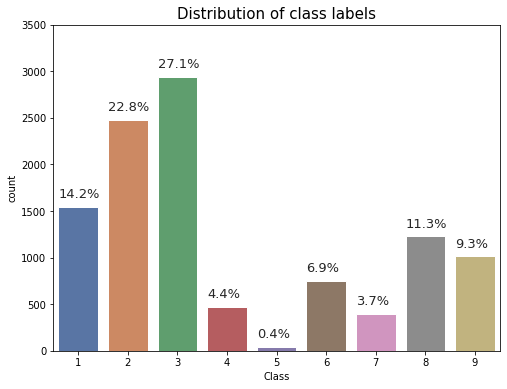

In [ ]:
Y=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trainLabels.csv")
total = len(Y)*1.
fig,ax1 = plt.subplots(figsize=(8,6))
sns.set_theme(style="darkgrid")
sns.countplot(x="Class", data=Y, ax=ax1)
ax1.yaxis.set_ticks(np.linspace(0, 3500, 8))

for p in ax1.patches:
        ax1.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()+100), fontsize=13) 

ax1.set_title('Distribution of class labels',fontsize=15)
plt.show()

## Part-1 : Feature extraction from byte files

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/data_size_byte.csv'):
    data_files = os.listdir('byteFiles')
    filenames = Y['Id'].tolist()
    class_y = Y.Class.values
    classbytes = []
    sizebytes = []
    fnames = []
    for file in data_files:
        statinfo = os.stat('byteFiles/'+file)
        file = file.split('.')[0]
        if any(file == filename for filename in filenames):
            i = filenames.index(file)
            classbytes.append(class_y[i])
            sizebytes.append(statinfo.st_size/(1024.0*1024.0))
            fnames.append(file)
        
    data_size_byte = pd.DataFrame({'Id':fnames, 'size':sizebytes, 'Class':classbytes})
    data_size_byte.head()
    data_size_byte.to_csv('/content/drive/MyDrive/Colab Notebooks/data_size_byte.csv', index=False)

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/csvs'):
    pairs_1 = product([0,1,2,3,4,5,6,7,8,9,'A','B','C','D','E','F'], [0,1,2,3,4,5,6,7,8,9,'A','B','C','D','E','F'])
    pairs_1 = [str(i[0])+str(i[1]) for i in pairs_1]
    pairs_2 = product(pairs_1, pairs_1)
    pairs_2 = [str(i[0])+str(i[1]) for i in pairs_2]

    no_features = len(pairs_1)+len(pairs_2) + 1
    names = []
    for i in os.listdir('/content/byteFiles'):
        names.append(str(i))
    names1 = names[:2717]
    names2 = names[2717:5343]
    names3 = names[5434:8151]
    names4 = names[8151:]
    lists = [names1, names2, names3, names4]

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/csvs'):
    for names in lists:
        byte_feature_file = open(f'/content/drive/MyDrive/Colab Notebooks/{names}.csv', 'w+')
        pairs = ['Id']+pairs_1+pairs_2+['??']
        byte_feature_file.write(','.join(pairs))
        byte_feature_file.write("\n")
        
        feature_matrix = np.zeros((len(names),no_features),dtype=int)
        k = 0

        for file in tqdm(names):
            byte_feature_file.write(str(file.split('.')[0])+',')
            with open('/content/byteFiles/'+file, 'r') as fp:
                for line in fp:
                    line = line.rstrip().split(' ')[1:]
                    i = 0
                    while i < len(line):
                        if line[i] == '??':
                            feature_matrix[k][no_features-1] += 1
                        else:
                            feature_matrix[k][int(str(line[i]), 16)] += 1
                        if i+1 < len(line):
                            if (line[i] == '??') or (line[i+1] == '??'):
                                feature_matrix[k][no_features-1] += 1
                            else:
                                feature_matrix[k][int(str(line[i]+line[i+1]) ,16)] += 1
                        i += 1
        
                fp.close()
            for i, row in enumerate(feature_matrix[k]):
                if i!=len(feature_matrix[k])-1:
                    byte_feature_file.write(str(row)+",")
                else:
                    byte_feature_file.write(str(row))
            k += 1
            byte_feature_file.write('\n')
            os.remove('/content/byteFiles/'+file)

        sp.save_npz(f'/content/drive/MyDrive/Colab Notebooks/{names}.npz', sp.csr_matrix(feature_matrix))
        byte_feature_file.close()

In [ ]:
# Finding max and min of each feature to normalize
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/maxes.npy'):
    maxes = []
    mins = []
    for i in tqdm(os.listdir('/content/drive/MyDrive/Colab Notebooks/csvs')[:-1]):
        df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csvs/'+i)
        maxes.append(df.max().values[1:])
        mins.append(df.min().values[1:])
        del df
        gc.collect()

    maxes = np.array(maxes)
    mins = np.array(mins)
    
    maxes = np.max(maxes, axis=0)
    mins = np.min(mins, axis=0)
    
    maxes = maxes.astype(np.float64)

    np.save('/content/drive/MyDrive/Colab Notebooks/maxes.npy', maxes)
    np.save('/content/drive/MyDrive/Colab Notebooks/mins.npy', mins)
else:
    maxes = np.load("/content/drive/MyDrive/Colab Notebooks/maxes.npy",allow_pickle=True)
    # maxes.astype(np.int64)
    mins = np.load("/content/drive/MyDrive/Colab Notebooks/mins.npy",allow_pickle=True)

In [ ]:
print(f"The number of nonzero maximum values in all the features: {np.count_nonzero(maxes)}. Out of {len(maxes)} features")

The number of nonzero maximum values in all the features: 65537. Out of 65793 features


In [ ]:
print(f"The number of nonzero minimum values in all the features: {np.count_nonzero(mins)}")

The number of nonzero minimum values in all the features: 0


In [ ]:
if not os.path.isdir("/content/drive/MyDrive/Colab Notebooks/New_npzs"):
    #Subtract all features with its corresponding minimum ans divide with its corresponding maximum
    for j,i in enumerate(os.listdir("/content/drive/MyDrive/Colab Notebooks/npzs")):
        n = sp.load_npz('/content/drive/MyDrive/Colab Notebooks/npzs/'+i)
        n = n.toarray()
        n = n.astype(np.float64)
        for i in range(n.shape[1]):
            if maxes[i] != 0:
                n[:,i] /= maxes[i]
        np.save(f'/content/fm{j+1}.npy',n)
        del n
        gc.collect()
        n1 = np.load(f"/content/fm{j+1}.npy")
        for i in range(n1.shape[0]):
            n1[i] = np.round(n1[i],3)
        print(n1)
        print(f"Size of n{j+1} :{np.round(n1.data.bytes/(1024**3),2)}GB")
        n1 = sp.csr_matrix(n1)
        sp.save_npz("/content/drive/MyDrive/Colab Notebooks/New_npzs/fm{j+1}.npz", n1)

In [ ]:
if not os.path.isfile("/content/drive/MyDrive/Colab Notebooks/final.npz"):
    n1 = sp.load_npz("/content/drive/MyDrive/Colab Notebooks/New_npzs/fm1.npz")
    n2 = sp.load_npz("/content/drive/MyDrive/Colab Notebooks/New_npzs/fm2.npz")
    n3 = sp.load_npz("/content/drive/MyDrive/Colab Notebooks/New_npzs/fm3.npz")
    n4 = sp.load_npz("/content/drive/MyDrive/Colab Notebooks/New_npzs/fm4.npz")
    fm = sp.vstack((n1,n2,n3,n4))
    sp.save_npz("/content/drive/MyDrive/Colab Notebooks/final.npz",fm)
    fm = sp.load_npz("/content/drive/MyDrive/Colab Notebooks/final.npz")
else:
    fm = sp.load_npz("/content/drive/MyDrive/Colab Notebooks/final.npz")

Variance preserved is: 94.665%


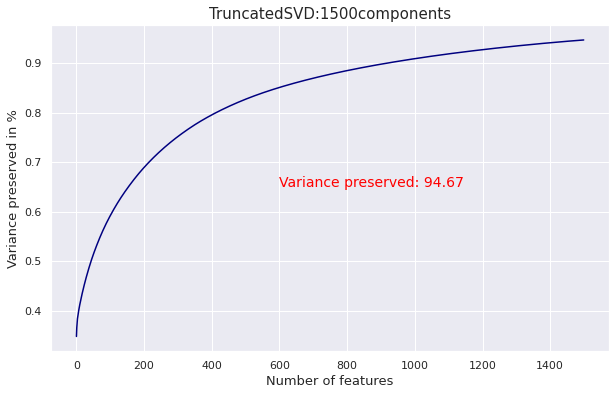

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components'):
    from sklearn.decomposition import TruncatedSVD
    tsvd = TruncatedSVD(n_components=1500, random_state=5)
    tsvd_data = tsvd.fit_transform(fm)
    c = tsvd.explained_variance_ratio_
    plt.plot(np.cumsum(c),c="navy")
    plt.grid()
    plt.title("SVD:1500components")
    plt.xlabel("Number of features")
    plt.ylabel("Variance preserved in %")
    plt.annotate(f'Variance preserved: {np.round(c.sum()*100,2)}', (600,0.65), fontsize=12, c='red')
    plt.show()
    print(f"Variance preserved: {c.sum()}%")
    del fm
    gc.collect()
    np.save("/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/tsvd_data.npy",tsvd_data)
    np.save("/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/tsvd_var_ratio_.npy",c)
    np.save("/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/tsvd_var_.npy",tsvd.explained_variance_)
else:
    del fm
    gc.collect()
    tsvd_data = np.load('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/tsvd_data.npy')
    tsvd_var_ratio = np.load("/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/tsvd_var_ratio_.npy")
    tsvd_var_ = np.load('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/tsvd_var_.npy')
    plt.figure(figsize=(10,6))
    plt.plot(np.cumsum(tsvd_var_ratio), c='navy')
    # plt.grid()
    plt.xlabel("Number of features", fontsize=13)
    plt.ylabel("Variance preserved in %", fontsize=13)
    plt.title("TruncatedSVD:1500components", fontsize=15)
    plt.annotate(f'Variance preserved: {np.round(tsvd_var_ratio.sum()*100,2)}', (600,0.65), fontsize=14, c='red')
    print(f'Variance preserved is: {np.round(tsvd_var_ratio.sum()*100,3)}%')

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/bi_gram.csv'):
    tsvd_data = np.round(tsvd_data ,2)#for easy computatiom
    tsvd_data = tsvd_data.astype(np.float32)# reduce size of dataframe
    pd.DataFrame(data=tsvd_data,
                index = range(tsvd_data.shape[0]),
                columns=[f'f{i}' for i in range(1,tsvd_data.shape[1]+1)]).to_csv('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/bi_gram.csv', index=False)

if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/result.csv'):
    bi_gram = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/bi_gram.csv')
    data_size_byte = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_size_byte.csv')
    bi_gram['Id'] = data_size_byte['Id']
    result = pd.merge(data_size_byte, bi_gram, on='Id', how='left')
    result.to_csv('/content/drive/MyDrive/Colab Notebooks/result.csv', index=False)
else:
    bi_gram = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tsvd_1500_components/bi_gram.csv')
    result = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/result.csv')
    display(result.head())
    data_y = result['Class']

Id       size  Class    f1    f2    f3    f4    f5    f6  \
0  EdruKXjgh0GO8BMPs4f1   8.113770      3  0.82  0.16 -0.01  0.20 -0.00  0.02   
1  92IMlB5PUDxYuGOw0dmE   1.132812      8  1.91  3.93 -3.18 -1.79 -1.17  0.23   
2  fbog6m7QU1kPDCHjSF4K   8.453613      2  9.00 -0.31  0.02 -0.17 -0.09 -0.21   
3  jhF9uVUQXrSw7bOt3Jkg  10.804199      3  0.02  0.01  0.00  0.01  0.00  0.00   
4  1hfkVAzp9jybt7YKEBrF   4.194933      2  2.89 -0.08 -0.00  0.01  0.00  0.03   

     f7  ...  f1491  f1492  f1493  f1494  f1495  f1496  f1497  f1498  f1499  \
0 -0.05  ...   0.01   0.00  -0.00  -0.00   0.01   0.00   0.00  -0.01   0.01   
1  0.15  ...  -0.08  -0.01   0.01   0.03   0.04  -0.11  -0.03   0.03  -0.01   
2 -0.03  ...   0.03   0.06   0.04   0.01  -0.02  -0.07   0.05  -0.01   0.09   
3  0.00  ...  -0.00   0.00   0.00  -0.00   0.00  -0.00  -0.00  -0.00  -0.00   
4  0.00  ...  -0.01  -0.01  -0.01   0.01  -0.01  -0.00  -0.01  -0.03  -0.00   

   f1500  
0  -0.01  
1  -0.09  
2   0.06  
3  -0.00  
4  -0.01  

[5 rows x 1503 columns]

In [ ]:
bi_gram.head()

f1    f2    f3    f4    f5    f6    f7    f8    f9   f10  ...  f1491  \
0  0.82  0.16 -0.01  0.20 -0.00  0.02 -0.05  0.02 -0.02 -0.03  ...   0.01   
1  1.91  3.93 -3.18 -1.79 -1.17  0.23  0.15  0.34 -0.02 -0.39  ...  -0.08   
2  9.00 -0.31  0.02 -0.17 -0.09 -0.21 -0.03 -0.10 -0.14  0.00  ...   0.03   
3  0.02  0.01  0.00  0.01  0.00  0.00  0.00 -0.00 -0.00  0.00  ...  -0.00   
4  2.89 -0.08 -0.00  0.01  0.00  0.03  0.00  0.03  0.03  0.01  ...  -0.01   

   f1492  f1493  f1494  f1495  f1496  f1497  f1498  f1499  f1500  
0   0.00  -0.00  -0.00   0.01   0.00   0.00  -0.01   0.01  -0.01  
1  -0.01   0.01   0.03   0.04  -0.11  -0.03   0.03  -0.01  -0.09  
2   0.06   0.04   0.01  -0.02  -0.07   0.05  -0.01   0.09   0.06  
3   0.00   0.00  -0.00   0.00  -0.00  -0.00  -0.00  -0.00  -0.00  
4  -0.01  -0.01   0.01  -0.01  -0.00  -0.01  -0.03  -0.00  -0.01  

[5 rows x 1500 columns]

## Multivariate Analysis

9it [2:08:03, 853.75s/it] 


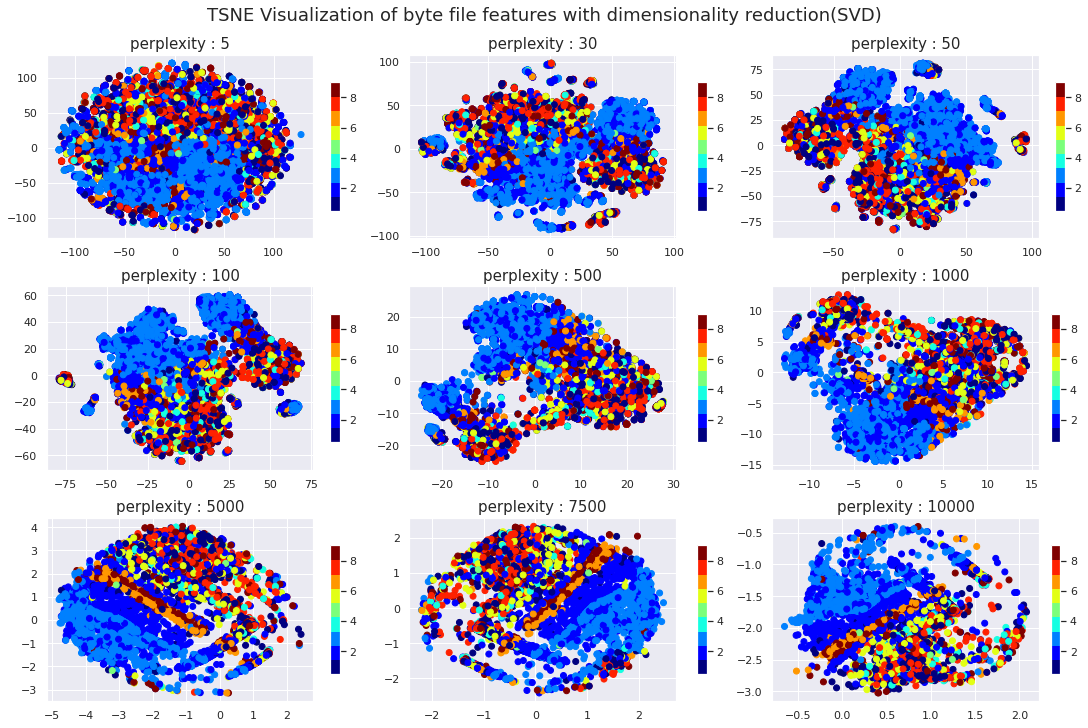

In [ ]:
#multivariate analysis on byte files
#this is with perplexity 50
perplex = [5, 30, 50, 100, 500, 1000, 5000, 7500, 10000]
fig, ax = plt.subplots(3,3, figsize=(15,10), constrained_layout=True)
ax = ax.flat
d = zip(ax, perplex)
fig.suptitle("TSNE Visualization of byte file features with dimensionality reduction(SVD)", fontsize=18)
for i,j in tqdm(d):
    xtsne=TSNE(perplexity=j)
    results=xtsne.fit_transform(result.drop(['Id','Class'], axis=1))
    vis_x = results[:, 0]
    vis_y = results[:, 1]
    im = i.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
    im.set_clim(0.5, 9)
    i.set_title(f"perplexity : {j}", fontsize=15)
    fig.colorbar(im, ax=i, shrink=0.7)
plt.show()

## Train Test split

In [ ]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['Id','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [ ]:
print('Number of data points in train data :', X_train.shape[0])
print('Number of data points in test data  :', X_test.shape[0])
print('Number of data points in cv data    :', X_cv.shape[0])

Number of data points in train data : 6955
Number of data points in test data  : 2174
Number of data points in cv data    : 1739


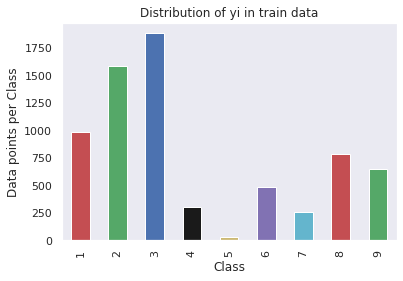

Number of data points in class 3 : 1883 ( 27.074 %)
Number of data points in class 2 : 1586 ( 22.804 %)
Number of data points in class 1 : 986 ( 14.177 %)
Number of data points in class 8 : 786 ( 11.301 %)
Number of data points in class 9 : 648 ( 9.317 %)
Number of data points in class 6 : 481 ( 6.916 %)
Number of data points in class 4 : 304 ( 4.371 %)
Number of data points in class 7 : 254 ( 3.652 %)
Number of data points in class 5 : 27 ( 0.388 %)
----------------------------------------------------------------------------------------------------------



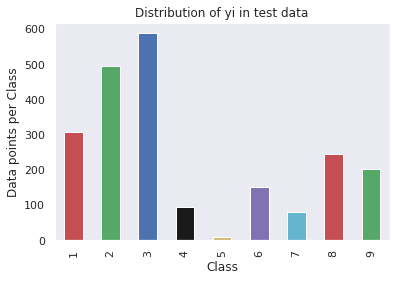

Number of data points in class 3 : 588 ( 27.047 %)
Number of data points in class 2 : 496 ( 22.815 %)
Number of data points in class 1 : 308 ( 14.167 %)
Number of data points in class 8 : 246 ( 11.316 %)
Number of data points in class 9 : 203 ( 9.338 %)
Number of data points in class 6 : 150 ( 6.9 %)
Number of data points in class 4 : 95 ( 4.37 %)
Number of data points in class 7 : 80 ( 3.68 %)
Number of data points in class 5 : 8 ( 0.368 %)
----------------------------------------------------------------------------------------------------------



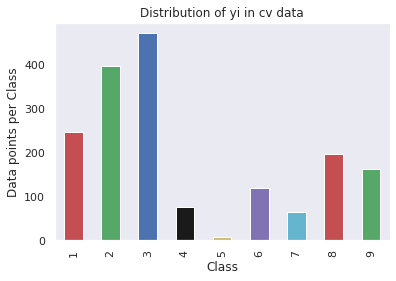

Number of data points in class 3 : 471 ( 27.085 %)
Number of data points in class 2 : 396 ( 22.772 %)
Number of data points in class 1 : 247 ( 14.204 %)
Number of data points in class 8 : 196 ( 11.271 %)
Number of data points in class 9 : 162 ( 9.316 %)
Number of data points in class 6 : 120 ( 6.901 %)
Number of data points in class 4 : 76 ( 4.37 %)
Number of data points in class 7 : 64 ( 3.68 %)
Number of data points in class 5 : 7 ( 0.403 %)


In [ ]:
train_class_distribution = y_train.value_counts().sort_index()
test_class_distribution = y_test.value_counts().sort_index()
cv_class_distribution = y_cv.value_counts().sort_index()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

print('-'*106)
print()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*106)
print()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y, labels=[*range(1,10)])
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(12,8))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(12,8))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(12,8))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

##Machine Learning Models
<h2>Machine Leaning Models on bytes files</h2>
<h3>Random Model</h3>

Log loss on Cross Validation Data using Random Model 2.4752098311292596
Log loss on Test Data using Random Model 2.4988857893529186
Number of misclassified points  89.28242870285189
-------------------------------------------------- Confusion matrix --------------------------------------------------


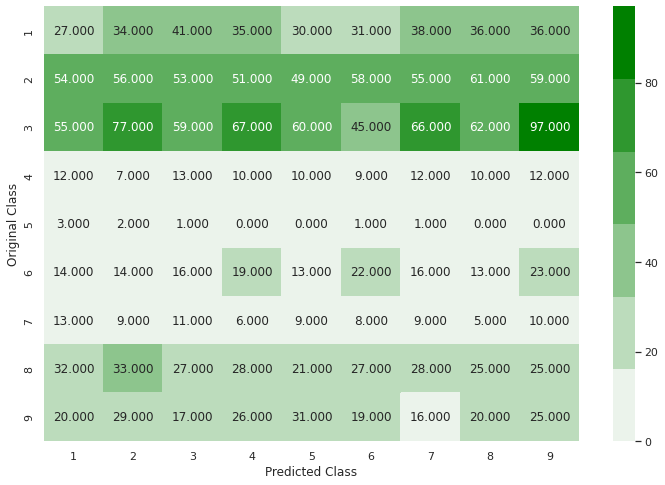

-------------------------------------------------- Precision matrix --------------------------------------------------


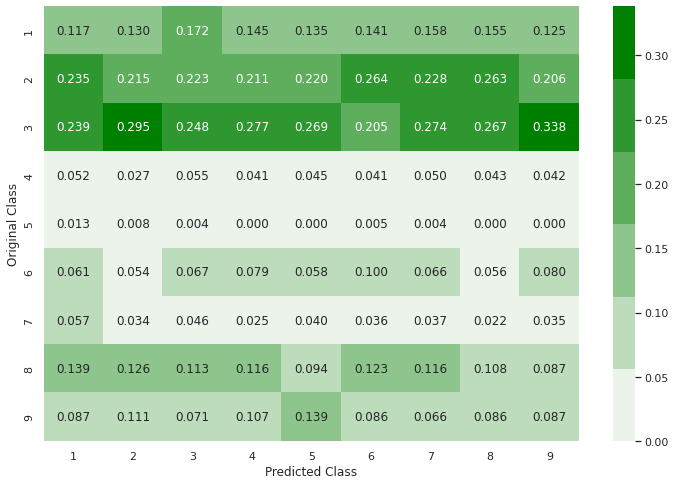

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


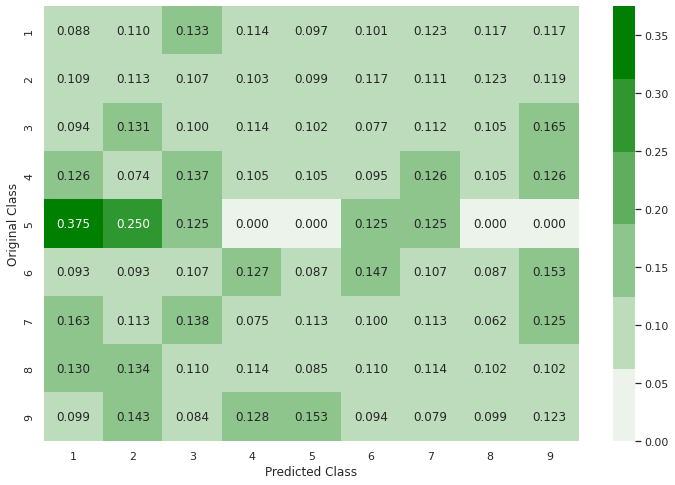

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h3>K Nearest Neighbour Classification</h3>

log_loss for k =  1 is 1.55426610392065
log_loss for k =  3 is 1.4078447586367109
log_loss for k =  5 is 1.3574930445491378
log_loss for k =  7 is 1.32908479453099
log_loss for k =  9 is 1.300636464125188
log_loss for k =  11 is 1.2798053695047955
log_loss for k =  13 is 1.2633136806616947


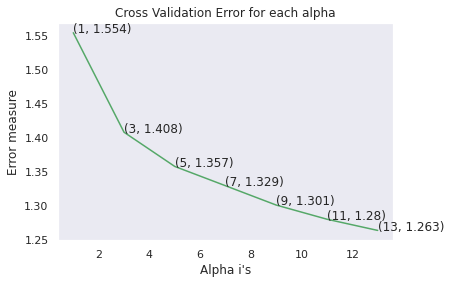

For values of best alpha =  13 The train log loss is: 1.0933324559750253
For values of best alpha =  13 The cross validation log loss is: 1.2633136806616947
For values of best alpha =  13 The test log loss is: 1.2687525465660408
Number of misclassified points  47.378104875804965
-------------------------------------------------- Confusion matrix --------------------------------------------------


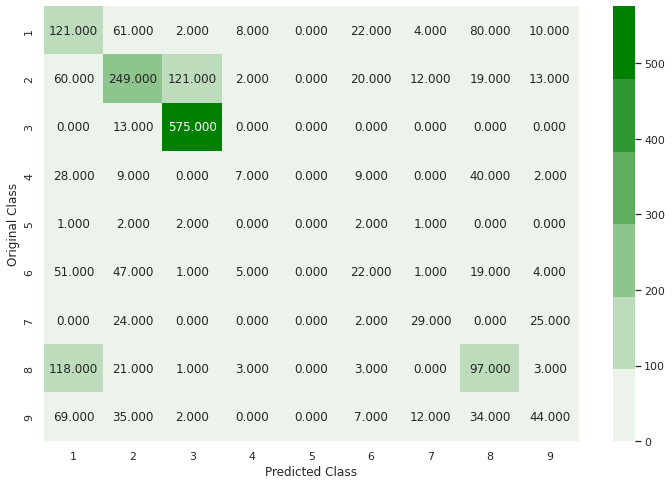

-------------------------------------------------- Precision matrix --------------------------------------------------


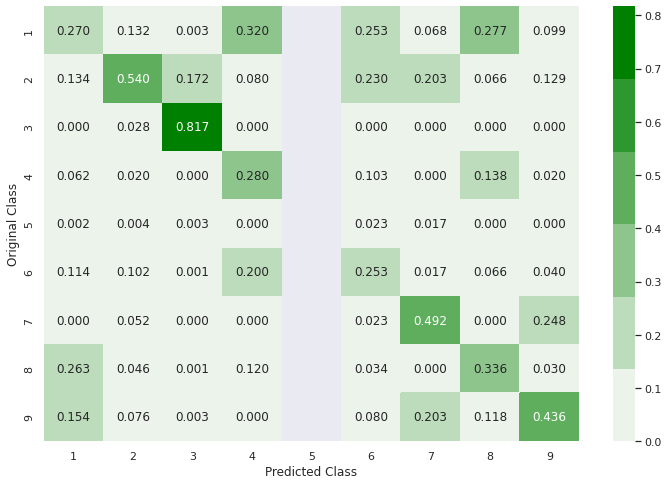

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


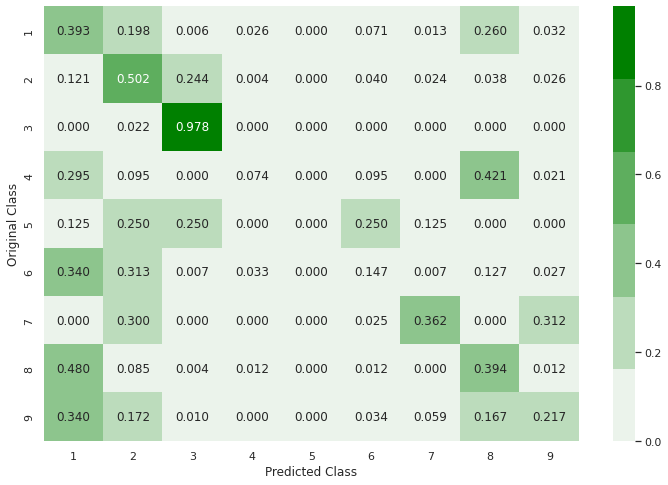

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from pandas.core.common import random_state
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i, random_state=5)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>Logistic Regression</h3>

log_loss for c =  1e-05 is 1.3772792634745001
log_loss for c =  0.0001 is 1.3742723534123389
log_loss for c =  0.001 is 1.371205096416749
log_loss for c =  0.01 is 1.3852762673512045
log_loss for c =  0.1 is 1.4187694910178166
log_loss for c =  1 is 1.481184208006463
log_loss for c =  10 is 1.5290835269229526
log_loss for c =  100 is 1.5327533132301738
log_loss for c =  1000 is 1.543368587753519


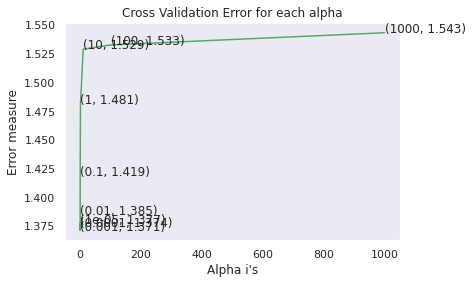

log loss for train data 1.3553695287349612
log loss for cv data 1.371205096416749
log loss for test data 1.3697929102742314
Number of misclassified points  50.73597056117756
-------------------------------------------------- Confusion matrix --------------------------------------------------


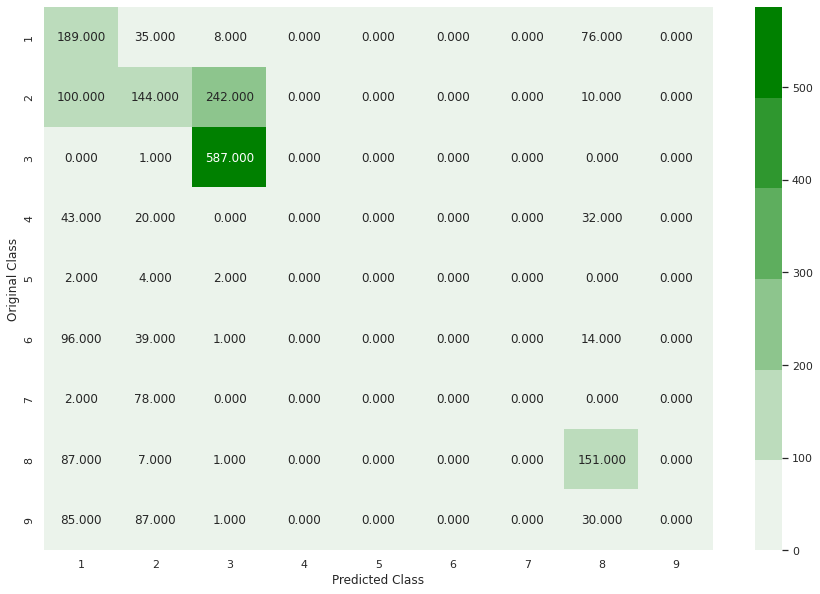

-------------------------------------------------- Precision matrix --------------------------------------------------


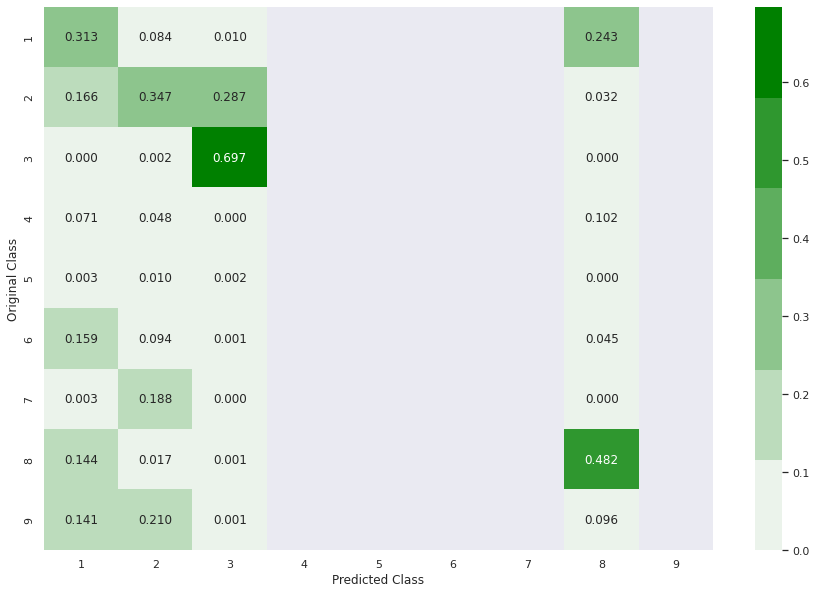

Sum of columns in precision matrix [ 1.  1.  1. nan nan nan nan  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


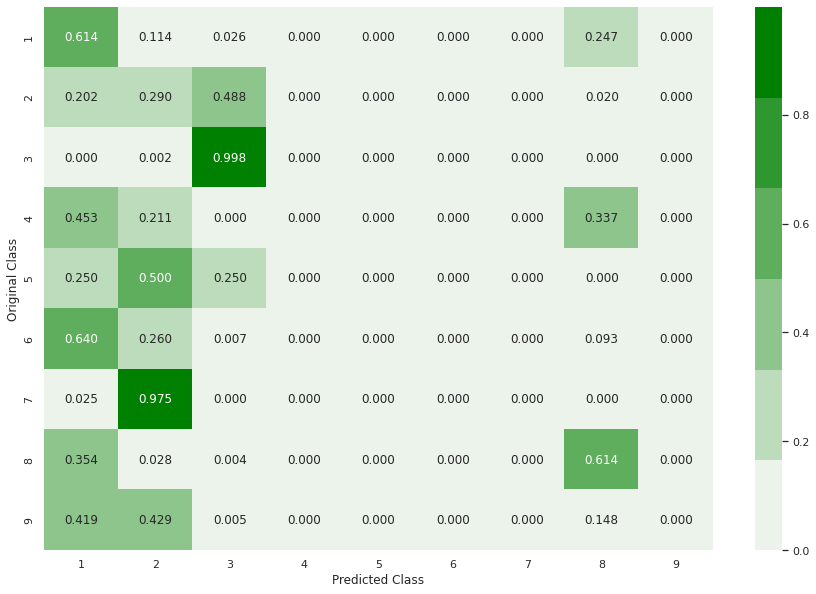

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced', random_state=5)
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>Random Forest Classifier </h3>

log_loss for c =  10 is 1.7539607172483245
log_loss for c =  50 is 1.6946435731884053
log_loss for c =  100 is 1.6794095248551242
log_loss for c =  500 is 1.6589538609276486
log_loss for c =  1000 is 1.6504041910747873
log_loss for c =  2000 is 1.6429005554418008
log_loss for c =  3000 is 1.6435908157313075


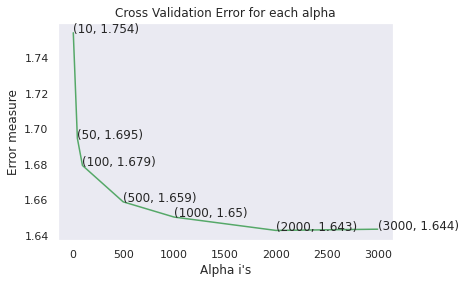

For values of best alpha =  2000 The train log loss is: 0.9829936492918163
For values of best alpha =  2000 The cross validation log loss is: 1.6429005554418008
For values of best alpha =  2000 The test log loss is: 1.6462784313442902
Number of misclassified points  59.06163753449862
-------------------------------------------------- Confusion matrix --------------------------------------------------


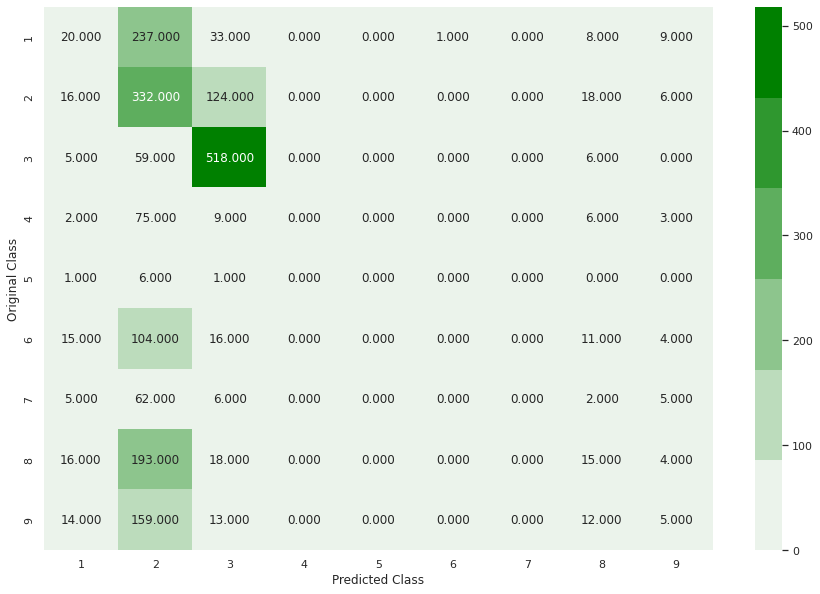

-------------------------------------------------- Precision matrix --------------------------------------------------


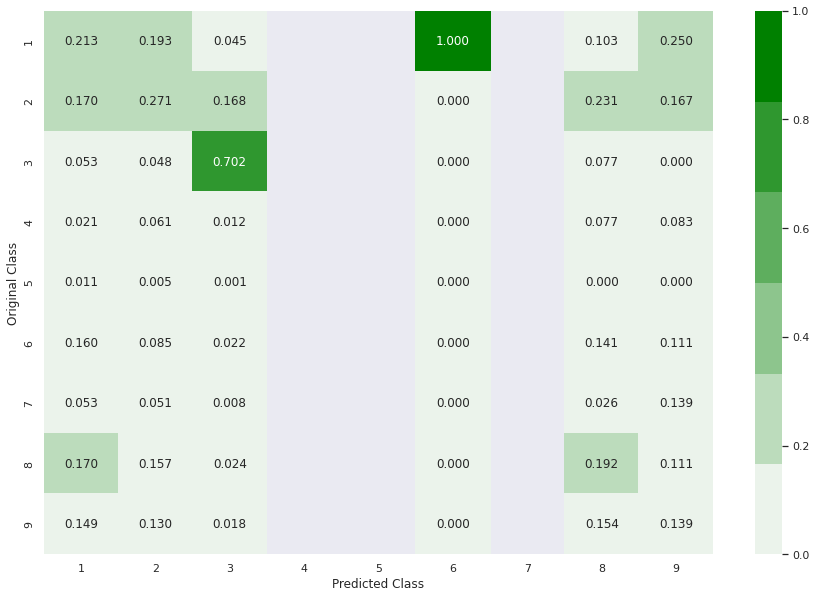

Sum of columns in precision matrix [ 1.  1.  1. nan nan  1. nan  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


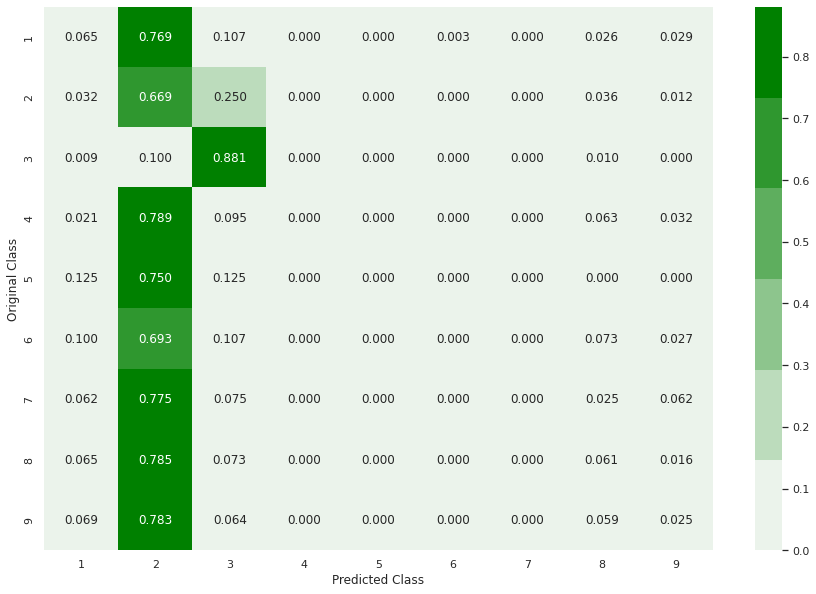

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>XgBoost Classification</h3>

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier(tree_method='gpu_hist', gpu_id=0, random_state=5)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(gpu_id=0, tree_method='gpu_hist'),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   verbose=10)

In [ ]:
print (random_cfl1.best_params_)

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
x_cfl=XGBClassifier(n_estimators=1000, learning_rate=0.05, colsample_bytree=1, max_depth=3, subsample= 0.5, tree_method='gpu_hist', gpu_id=0)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.33436385507136807
cv loss 0.8902613603118473
test loss 0.870567866065733


# Part-2 : asmFiles

## Feature extraction from asm files

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/asm_with_size.csv'):
    from asm_file_processimg import main
    main()
else:
    dfasm=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/asmoutputfile.csv")
    dfasm.rename(columns={'ID':"Id"}, inplace=True)
    Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trainLabels.csv')
    result_asm = pd.merge(dfasm, Y,on='Id', how='left')
    display(result_asm.head(2))

Id  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   

   .rdata:  .edata:  .rsrc:  ...  edx  esi  eax  ebx  ecx  edi  ebp  esp  eip  \
0      323        0       3  ...   18   66   15   43   83    0   17   48   29   
1        0        0       3  ...   18   29   48   82   12    0   14    0   20   

   Class  
0      1  
1      1  

[2 rows x 53 columns]

## Files sizes of each .asm file

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/asm_with_size.csv'):
    files=os.listdir('asmFiles')
    filenames=Y['ID'].tolist()
    class_y=Y['Class'].tolist()
    class_bytes=[]
    sizebytes=[]
    fnames=[]
    for file in files:
        # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
        # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
        # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
        # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
        statinfo=os.stat('asmFiles/'+file)
        # split the file name at '.' and take the first part of it i.e the file name
        file=file.split('.')[0]
        if any(file == filename for filename in filenames):
            i=filenames.index(file)
            class_bytes.append(class_y[i])
            # converting into Mb's
            sizebytes.append(statinfo.st_size/(1024.0*1024.0))
            fnames.append(file)
    asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
    print(asm_size_byte.head())
else:
    asm_size_byte = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/asm_with_size.csv')
    asm_size_byte.rename(columns={'ID':"Id"}, inplace=True)
    display(asm_size_byte.head(3))

Unnamed: 0                    Id   size_asm  Class
0           0  01azqd4InC7m9JpocGv5  56.229886      9
1           1  01IsoiSMh5gxyDYTl4CB  13.999378      2
2           2  01jsnpXSAlgw6aPeDxrU   8.507785      9

## Distribution of .asm file sizes

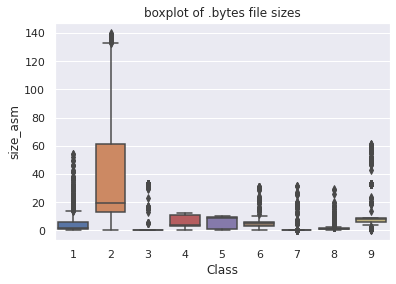

In [ ]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size_asm", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [ ]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class'], axis=1),on='Id', how='left')
# result_asm.rename(columns={'ID':"Id"}, inplace=True)
display(result_asm.head(2))

(10868, 53)
(10868, 4)


Id  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   

   .rdata:  .edata:  .rsrc:  ...  eax  ebx  ecx  edi  ebp  esp  eip  Class  \
0      323        0       3  ...   15   43   83    0   17   48   29      1   
1        0        0       3  ...   48   82   12    0   14    0   20      1   

   Unnamed: 0  size_asm  
0           3   0.07819  
1         438   0.06340  

[2 rows x 55 columns]

In [ ]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('Id') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            result1.round(5)
    return result1
result_asm = normalize(result_asm)
display(result_asm.head())

Id   HEADER:    .text:  .Pav:   .idata:    .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju  0.107345  0.001092    0.0  0.000761  0.000023    0.0   
1  1E93CpP60RHFNiT5Qfvn  0.096045  0.001230    0.0  0.000617  0.000019    0.0   
2  3ekVow2ajZHbTnBcsDfX  0.096045  0.000627    0.0  0.000300  0.000017    0.0   
3  3X2nY7iQaPBIWDrAZqJe  0.096045  0.000333    0.0  0.000258  0.000008    0.0   
4  46OZzdsSKDCFV8h7XWxf  0.096045  0.000590    0.0  0.000353  0.000068    0.0   

    .rdata:  .edata:    .rsrc:  ...       eax       ebx       ecx  edi  \
0  0.000084      0.0  0.000072  ...  0.000301  0.000360  0.001057  0.0   
1  0.000000      0.0  0.000072  ...  0.000965  0.000686  0.000153  0.0   
2  0.000038      0.0  0.000072  ...  0.000201  0.000560  0.000178  0.0   
3  0.000000      0.0  0.000072  ...  0.000281  0.000059  0.000025  0.0   
4  0.000000      0.0  0.000072  ...  0.000362  0.000243  0.000064  0.0   

        ebp       esp       eip  Class  Unnamed: 0  size_asm  
0  0.030797  0.001468  0.003173      1    0.000276  0.000432  
1  0.025362  0.000000  0.002188      1    0.040306  0.000327  
2  0.019928  0.000000  0.000985      1    0.104813  0.000172  
3  0.014493  0.000000  0.000657      1    0.123953  0.000009  
4  0.019928  0.000000  0.001204      1    0.130211  0.000143  

[5 rows x 55 columns]

###  Univariate analysis on asm file features

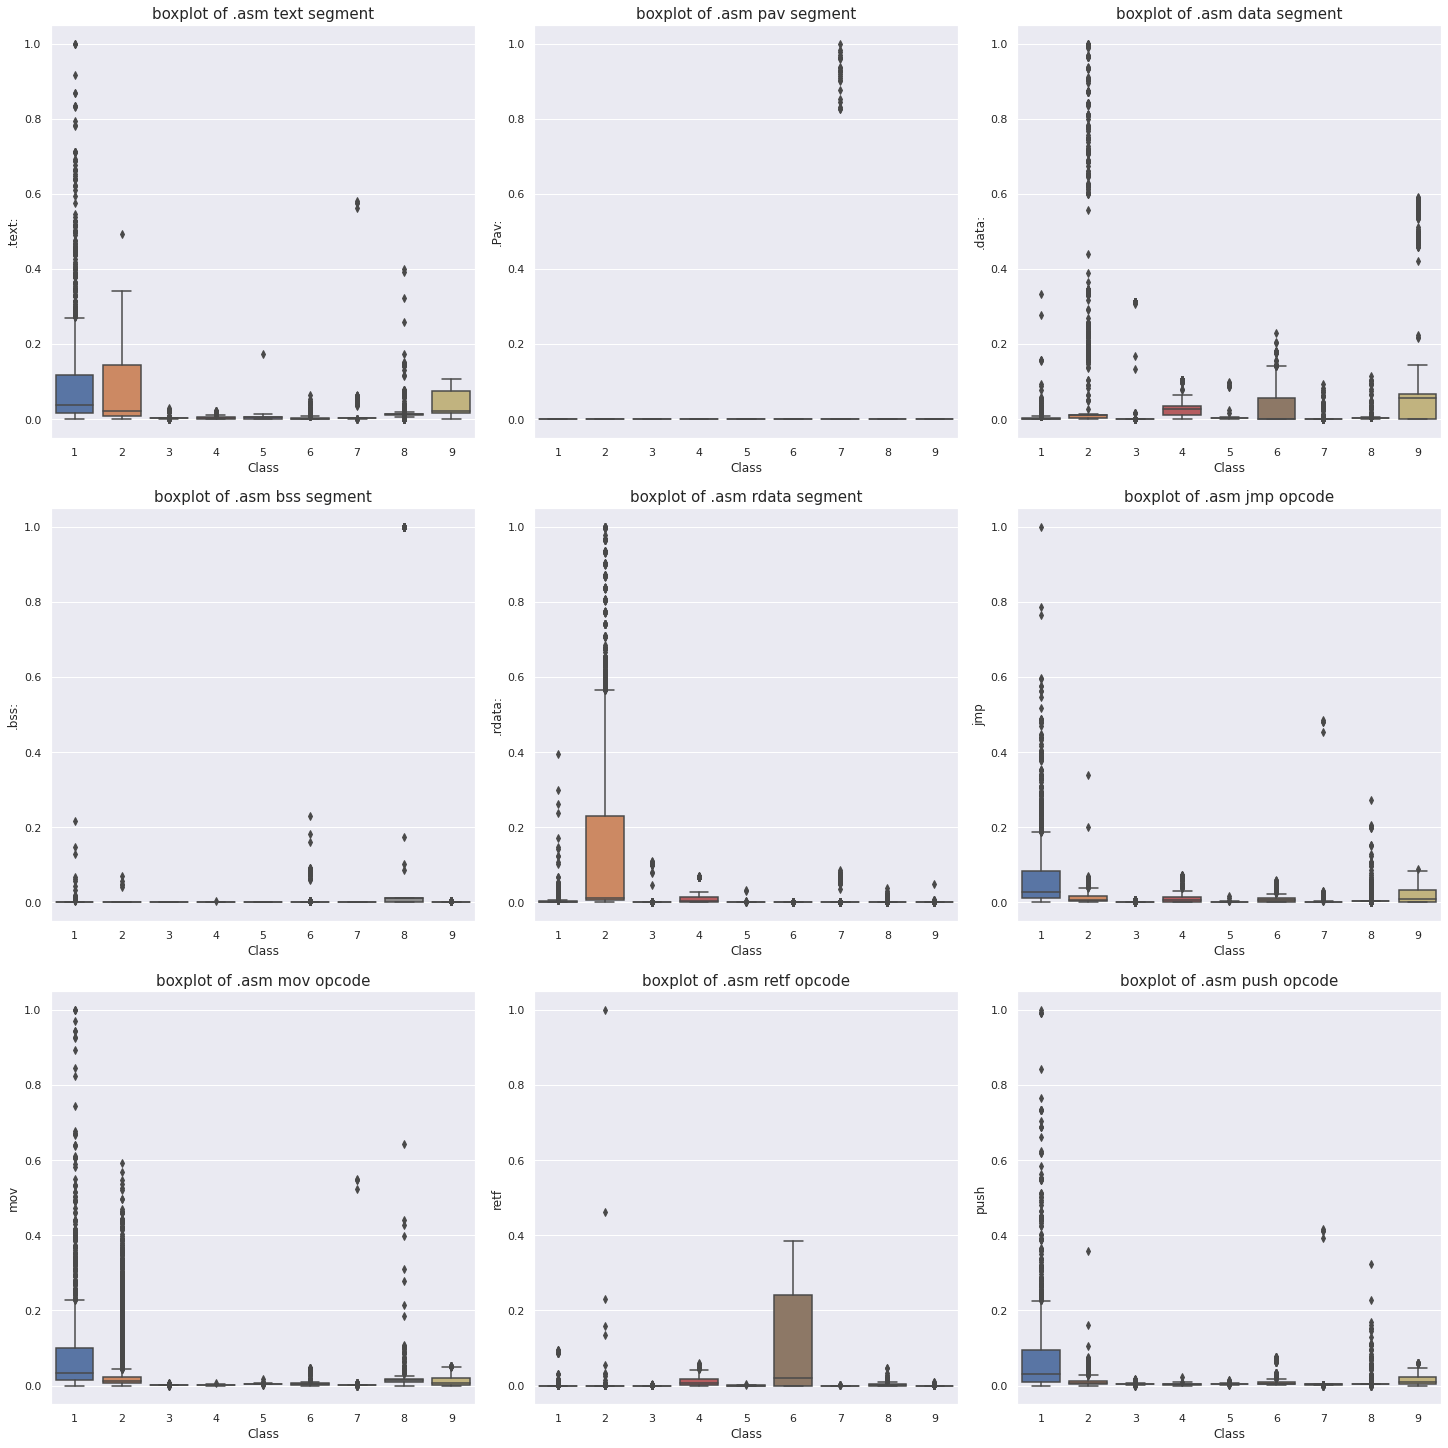

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(20,20), constrained_layout=True)
ax = ax.flat
sns.boxplot(x="Class", y=".text:", data=result_asm, ax=ax[0])
ax[0].set_title("boxplot of .asm text segment", fontsize=15)
sns.boxplot(x="Class", y=".Pav:", data=result_asm, ax=ax[1])
ax[1].set_title("boxplot of .asm pav segment", fontsize=15)
sns.boxplot(x="Class", y=".data:", data=result_asm, ax=ax[2])
ax[2].set_title("boxplot of .asm data segment", fontsize=15)
sns.boxplot(x="Class", y=".bss:", data=result_asm, ax=ax[3])
ax[3].set_title("boxplot of .asm bss segment", fontsize=15)
sns.boxplot(x="Class", y=".rdata:", data=result_asm, ax=ax[4])
ax[4].set_title("boxplot of .asm rdata segment", fontsize=15)
sns.boxplot(x="Class", y="jmp", data=result_asm, ax=ax[5])
ax[5].set_title("boxplot of .asm jmp opcode", fontsize=15)
sns.boxplot(x="Class", y="mov", data=result_asm, ax=ax[6])
ax[6].set_title("boxplot of .asm mov opcode", fontsize=15)
sns.boxplot(x="Class", y="retf", data=result_asm, ax=ax[7])
ax[7].set_title("boxplot of .asm retf opcode", fontsize=15)
sns.boxplot(x="Class", y="push", data=result_asm, ax=ax[8])
ax[8].set_title("boxplot of .asm push opcode", fontsize=15)
plt.show()

## asm pixel intensities

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/pixels/pixel_intensities.csv'):
    def file_2_image(sourcepath, destpath):
        start = datetime.now()
        files = os.listdir(sourcepath)
        print('started..,')
        for file in tqdm(files):
            f = codecs.open(sourcepath+file, 'rb')
            length = os.path.getsize(sourcepath+file)
            width = int(length**0.5)
            rem = int(length/width)
            a = array.array("B")
            a.frombytes(f.read())
            f.close()
            g = np.reshape(a[:width*width], (width, width))
            g = np.uint8(g)
            imageio.imwrite(destpath+file+'.png',g)
        print("Files converted Successfully ",len(files),' files')
        print("Time taken: ", (datetime.now()-start))


    def img2pix(source, dest):
        file = open(dest, 'w+')
        file.write('Id'+',')
        l = [f'f_{i}' for i in range(1,801)] 
        file.write(','.join(l))
        file.write("\n")
        data_files = os.listdir(source)
        for i in tqdm(data_files):
            img = cv2.imread(source+str(i),0).flatten()[:800]
            file.write(i.split('.')[0]+',')
            for j in img:
                file.write(str(j)+',')
            file.write('\n')
        file.close()
    
    #asm file images
    source = 'asmFile'
    data_files = os.listdir('asmFiles')
    dest = 'asmFile_images/'
    for i in data_files:
        file_2_image(source, dest)
    #asmFile pixels
    data_files = os.listdir('asmFile_images')
    source = 'asmFile_images'
    dest = 'asmFile_pixels/asm_pixel.csv'
    for i in data_files:
        img2pix(source, dest)
    df1 = pd.read_csv('asm_pixel.csv')

    #Byte file images
    source = 'byteFile'
    data_files = os.listdir('byteFile')
    dest = 'byteFile_images/'
    for i in data_files:
        file_2_image(source, dest)
    #asmFile pixels
    data_files = os.listdir('byteFile_images')
    source = 'byteFile_images'
    dest = 'byteFile_pixels/byte_pixel.csv'
    for i in data_files:
        img2pix(source, dest)
    df2 = pd.read_csv('byte_pixel.csv')

    data = pd.merge(df1, df2, on='Id', how="inner")
    data.to_csv('pixel_intensities.csv', ignore_index=True)

else:
    pixel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pixels/pixel_intensities.csv')
    # pixel = normalize(pixel)
    display(pixel.head(3))

Id  a_1  a_2  a_3  a_4  a_5  a_6  a_7  a_8  a_9  ...  \
0  epj8anqLcrRxHGVWT1Bg   72   69   65   68   69   82   58   48   48  ...   
1  hDNYlkuFK3cOtqEywM6f   72   69   65   68   69   82   58   48   48  ...   
2  hnEAVHz5I7tQcjGWvRi1   46  116  101  120  116   58   48   48   52  ...   

   b_791  b_792  b_793  b_794  b_795  b_796  b_797  b_798  b_799  b_800  
0     48     32     48     48     32     48     48     32     70     70  
1     69     32     70     70     32     70     70     32     53     57  
2     57     32     55     65     32     52     48     32     56     57  

[3 rows x 1601 columns]

In [ ]:
#merge pixel and result asm
result_asm = pd.merge(result_asm, pixel, on="Id", how="inner")
result_asm.head(2)

Id   HEADER:    .text:  .Pav:   .idata:    .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju  0.107345  0.001092    0.0  0.000761  0.000023    0.0   
1  1E93CpP60RHFNiT5Qfvn  0.096045  0.001230    0.0  0.000617  0.000019    0.0   

    .rdata:  .edata:    .rsrc:  ...  b_791  b_792  b_793  b_794  b_795  b_796  \
0  0.000084      0.0  0.000072  ...     48     32     48     48     32     53   
1  0.000000      0.0  0.000072  ...     48     32     52     51     32     52   

   b_797  b_798  b_799  b_800  
0     50     32     56     68  
1     67     32     53     51  

[2 rows x 1655 columns]

### Multivariate Analysis on .asm file features

4it [11:53, 178.39s/it]


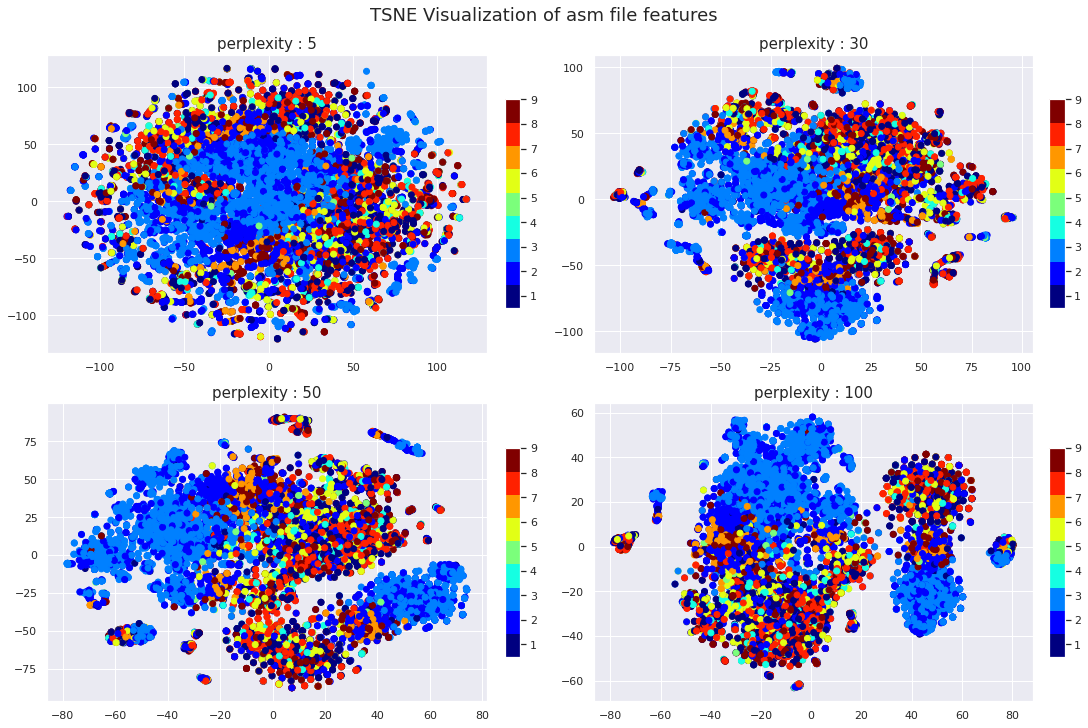

In [ ]:
perplex = [5, 30, 50, 100, 500, 100]
fig, ax = plt.subplots(2,3, figsize=(15,10), constrained_layout=True)
ax = ax.flat
d = zip(ax, perplex)
fig.suptitle("TSNE Visualization of asm file features", fontsize=18)
for i,j in tqdm(d):
    xtsne=TSNE(perplexity=j)
    results=xtsne.fit_transform(result.drop(['Id','Class'], axis=1))
    vis_x = results[:, 0]
    vis_y = results[:, 1]
    im = i.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
    im.set_clim(0.5, 9)
    i.set_title(f"perplexity : {j}", fontsize=15)
    fig.colorbar(im, ax=i, shrink=0.7)
plt.show()

## Train and test split

In [ ]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['Id','Class','.BSS:','rtn','.CODE'], axis=1)

In [ ]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [ ]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
           ...  
b_796      False
b_797      False
b_798      False
b_799      False
b_800      False
Length: 1650, dtype: bool


## Machine Learning models on features of .asm files

### K-Nearest Neigbors

log_loss for k =  1 is 0.8854283589465657
log_loss for k =  3 is 0.8376416520843758
log_loss for k =  5 is 0.8207491231987493
log_loss for k =  7 is 0.8251942528466005
log_loss for k =  9 is 0.830361683380381
log_loss for k =  11 is 0.8359469582668104
log_loss for k =  13 is 0.8363948404545296
log_loss for k =  15 is 0.8217864395512532
log_loss for k =  17 is 0.805069882251987
log_loss for k =  19 is 0.7888906257030878


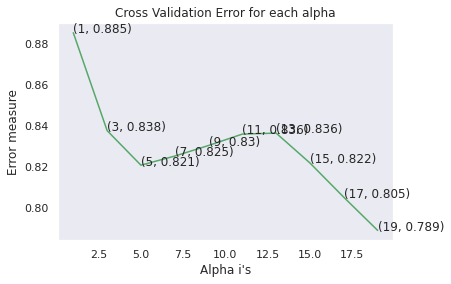

log loss for train data 0.7061550868988348
log loss for cv data 0.7888906257030878
log loss for test data 0.7918041306848134
Number of misclassified points  25.252989880404787
-------------------------------------------------- Confusion matrix --------------------------------------------------


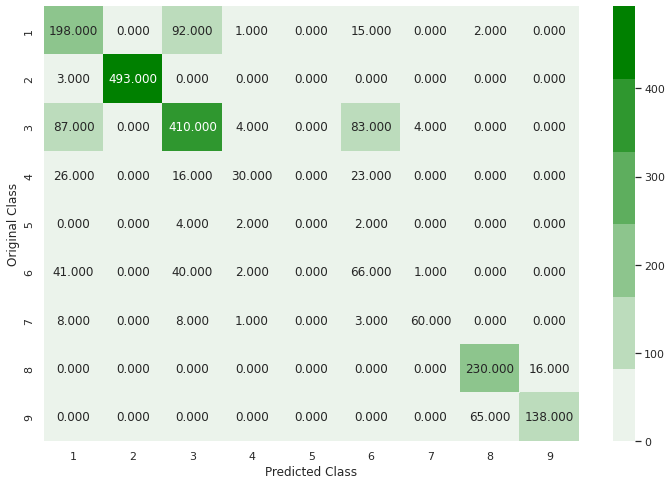

-------------------------------------------------- Precision matrix --------------------------------------------------


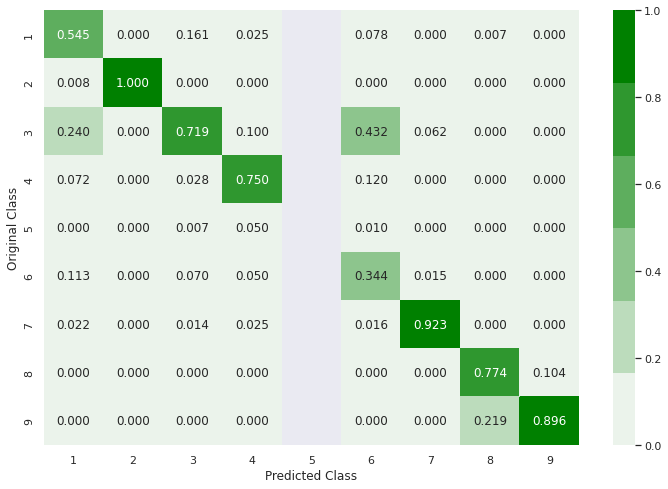

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


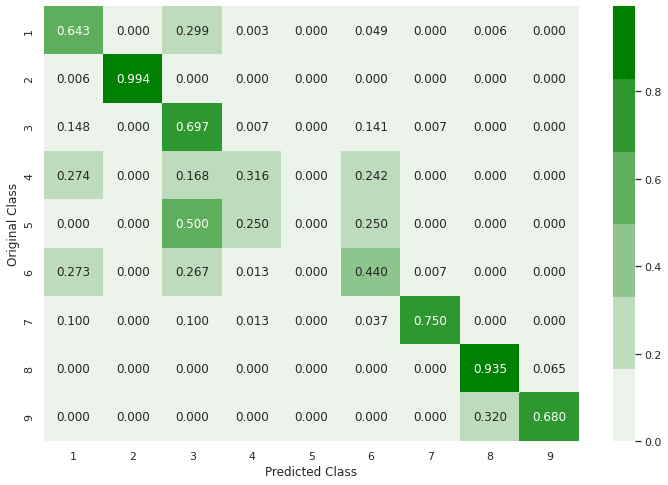

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

### Logistic Regression

log_loss for c =  1e-05 is 1.6772798088582155
log_loss for c =  0.0001 is 1.6766483199694606
log_loss for c =  0.001 is 1.6801357052849901
log_loss for c =  0.01 is 1.679667651807601
log_loss for c =  0.1 is 1.6794283392263176
log_loss for c =  1 is 1.6774744789622393
log_loss for c =  10 is 1.6781835827897706
log_loss for c =  100 is 1.678188602069071
log_loss for c =  1000 is 1.677893200626735


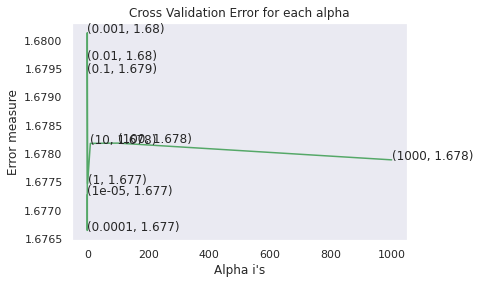

log loss for train data 1.6785204574171193
log loss for cv data 1.6766483199694606
log loss for test data 1.671783895074047
Number of misclassified points  55.93376264949402
-------------------------------------------------- Confusion matrix --------------------------------------------------


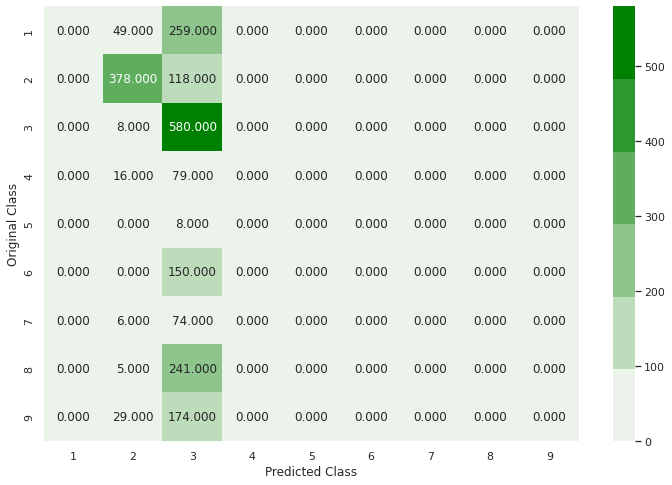

-------------------------------------------------- Precision matrix --------------------------------------------------


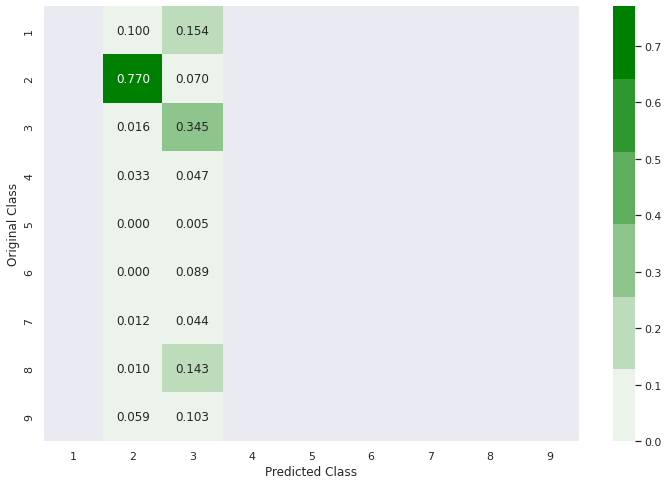

Sum of columns in precision matrix [nan  1.  1. nan nan nan nan nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


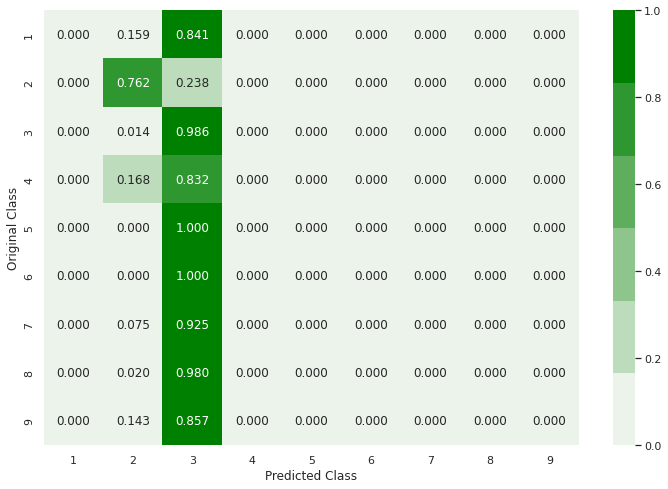

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

### Random Forest Classifier

log_loss for c =  10 is 0.041651859611280075
log_loss for c =  50 is 0.03568125591884417
log_loss for c =  100 is 0.03471224791695174
log_loss for c =  500 is 0.03444712137088919
log_loss for c =  1000 is 0.03481760474324767
log_loss for c =  2000 is 0.035254496776161826
log_loss for c =  3000 is 0.035293543309487634


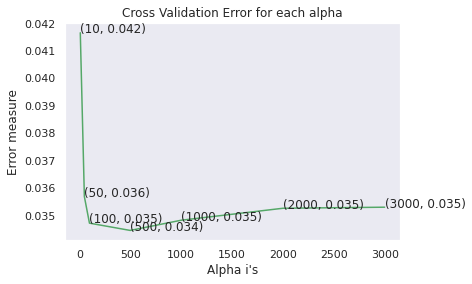

log loss for train data 0.013265549942141311
log loss for cv data 0.03444712137088919
log loss for test data 0.033659009228456105
Number of misclassified points  0.7359705611775529
-------------------------------------------------- Confusion matrix --------------------------------------------------


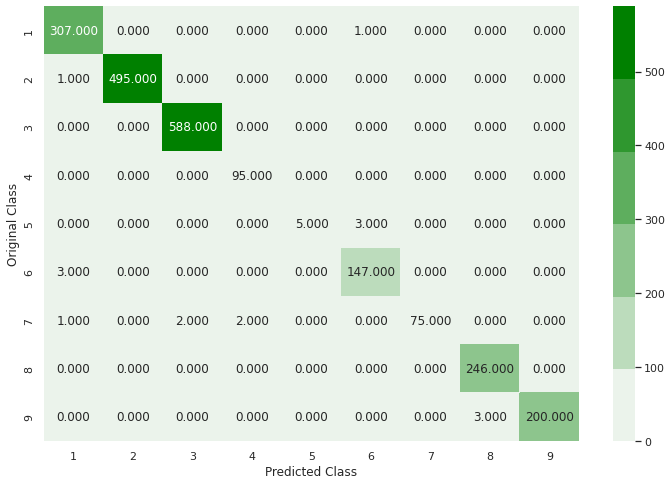

-------------------------------------------------- Precision matrix --------------------------------------------------


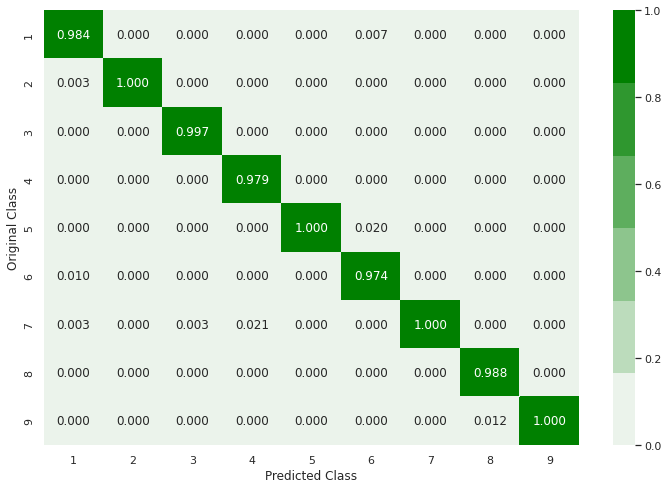

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


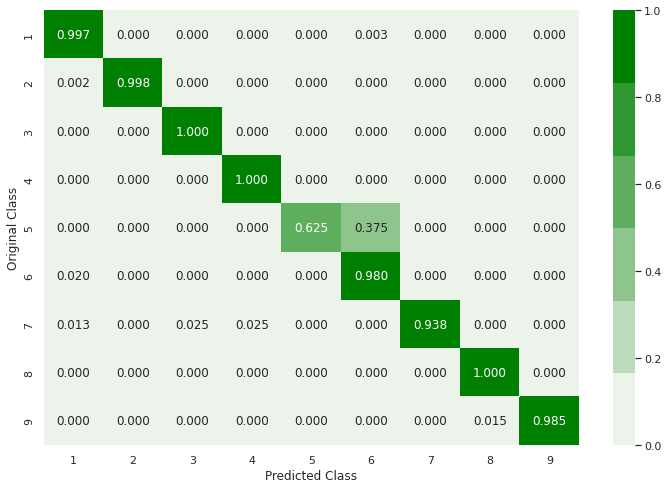

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

### XgBoost Classifier

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_asm = le.fit_transform(y_train_asm)

In [ ]:
x_cfl=XGBClassifier(tree_method='gpu_hist', gpu_id=0)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.5],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_asm,y_train_asm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=0, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_...
                                           monotone_constraints=None,
                                           n

In [ ]:
print (random_cfl.best_params_)
print (random_cfl.best_estimator_)

{'subsample': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.3}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [ ]:
x_cfl=random_cfl.best_estimator_
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)

predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))

train loss 0.011470979843923933
cv loss 0.031991008188828406
test loss 0.02349402959481264


# Machine Learning models on features of both .asm and .bytes files

In [ ]:
result.head()

Id       size  Class    f1    f2    f3    f4    f5    f6  \
0  EdruKXjgh0GO8BMPs4f1   8.113770      3  0.82  0.16 -0.01  0.20 -0.00  0.02   
1  92IMlB5PUDxYuGOw0dmE   1.132812      8  1.91  3.93 -3.18 -1.79 -1.17  0.23   
2  fbog6m7QU1kPDCHjSF4K   8.453613      2  9.00 -0.31  0.02 -0.17 -0.09 -0.21   
3  jhF9uVUQXrSw7bOt3Jkg  10.804199      3  0.02  0.01  0.00  0.01  0.00  0.00   
4  1hfkVAzp9jybt7YKEBrF   4.194933      2  2.89 -0.08 -0.00  0.01  0.00  0.03   

     f7  ...  f1491  f1492  f1493  f1494  f1495  f1496  f1497  f1498  f1499  \
0 -0.05  ...   0.01   0.00  -0.00  -0.00   0.01   0.00   0.00  -0.01   0.01   
1  0.15  ...  -0.08  -0.01   0.01   0.03   0.04  -0.11  -0.03   0.03  -0.01   
2 -0.03  ...   0.03   0.06   0.04   0.01  -0.02  -0.07   0.05  -0.01   0.09   
3  0.00  ...  -0.00   0.00   0.00  -0.00   0.00  -0.00  -0.00  -0.00  -0.00   
4  0.00  ...  -0.01  -0.01  -0.01   0.01  -0.01  -0.00  -0.01  -0.03  -0.00   

   f1500  
0  -0.01  
1  -0.09  
2   0.06  
3  -0.00  
4  -0.01  

[5 rows x 1503 columns]

In [ ]:

result_asm.head()

Id   HEADER:    .text:  .Pav:   .idata:    .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju  0.107345  0.001092    0.0  0.000761  0.000023    0.0   
1  1E93CpP60RHFNiT5Qfvn  0.096045  0.001230    0.0  0.000617  0.000019    0.0   
2  3ekVow2ajZHbTnBcsDfX  0.096045  0.000627    0.0  0.000300  0.000017    0.0   
3  3X2nY7iQaPBIWDrAZqJe  0.096045  0.000333    0.0  0.000258  0.000008    0.0   
4  46OZzdsSKDCFV8h7XWxf  0.096045  0.000590    0.0  0.000353  0.000068    0.0   

    .rdata:  .edata:    .rsrc:  ...  b_791  b_792  b_793  b_794  b_795  b_796  \
0  0.000084      0.0  0.000072  ...     48     32     48     48     32     53   
1  0.000000      0.0  0.000072  ...     48     32     52     51     32     52   
2  0.000038      0.0  0.000072  ...     50     32     70     70     32     57   
3  0.000000      0.0  0.000072  ...     48     32     48     48     32     53   
4  0.000000      0.0  0.000072  ...     48     32     57     48     32     57   

   b_797  b_798  b_799  b_800  
0     50     32     56     68  
1     67     32     53     51  
2     48     32     65     52  
3     69     32     55     53  
4     48     32     57     48  

[5 rows x 1655 columns]

In [ ]:
result_x = pd.merge(result_asm.drop(['Class'], axis=1), result, on='Id', how='inner')

In [ ]:
result_x.head()

Id   HEADER:    .text:  .Pav:   .idata:    .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju  0.107345  0.001092    0.0  0.000761  0.000023    0.0   
1  1E93CpP60RHFNiT5Qfvn  0.096045  0.001230    0.0  0.000617  0.000019    0.0   
2  3ekVow2ajZHbTnBcsDfX  0.096045  0.000627    0.0  0.000300  0.000017    0.0   
3  3X2nY7iQaPBIWDrAZqJe  0.096045  0.000333    0.0  0.000258  0.000008    0.0   
4  46OZzdsSKDCFV8h7XWxf  0.096045  0.000590    0.0  0.000353  0.000068    0.0   

    .rdata:  .edata:    .rsrc:  ...  f1491  f1492  f1493  f1494  f1495  f1496  \
0  0.000084      0.0  0.000072  ...   0.01  -0.01  -0.02  -0.01  -0.00   0.01   
1  0.000000      0.0  0.000072  ...  -0.01  -0.01   0.00  -0.01  -0.02  -0.02   
2  0.000038      0.0  0.000072  ...  -0.07  -0.02  -0.01  -0.06   0.10  -0.07   
3  0.000000      0.0  0.000072  ...  -0.05   0.10  -0.00  -0.06  -0.01   0.06   
4  0.000000      0.0  0.000072  ...   0.00   0.00   0.02  -0.00  -0.03   0.01   

   f1497  f1498  f1499  f1500  
0  -0.00  -0.00   0.01   0.00  
1  -0.02  -0.01  -0.01   0.00  
2   0.09   0.06   0.00  -0.02  
3  -0.06   0.05   0.07  -0.01  
4   0.02  -0.01  -0.02   0.00  

[5 rows x 3156 columns]

In [ ]:
result_y = result_x['Class']
result_x = result_x.drop(['Id','rtn','.BSS:','.CODE','Class'], axis=1)
result_x.head()

HEADER:    .text:  .Pav:   .idata:    .data:  .bss:   .rdata:  .edata:  \
0  0.107345  0.001092    0.0  0.000761  0.000023    0.0  0.000084      0.0   
1  0.096045  0.001230    0.0  0.000617  0.000019    0.0  0.000000      0.0   
2  0.096045  0.000627    0.0  0.000300  0.000017    0.0  0.000038      0.0   
3  0.096045  0.000333    0.0  0.000258  0.000008    0.0  0.000000      0.0   
4  0.096045  0.000590    0.0  0.000353  0.000068    0.0  0.000000      0.0   

     .rsrc:  .tls:  ...  f1491  f1492  f1493  f1494  f1495  f1496  f1497  \
0  0.000072    0.0  ...   0.01  -0.01  -0.02  -0.01  -0.00   0.01  -0.00   
1  0.000072    0.0  ...  -0.01  -0.01   0.00  -0.01  -0.02  -0.02  -0.02   
2  0.000072    0.0  ...  -0.07  -0.02  -0.01  -0.06   0.10  -0.07   0.09   
3  0.000072    0.0  ...  -0.05   0.10  -0.00  -0.06  -0.01   0.06  -0.06   
4  0.000072    0.0  ...   0.00   0.00   0.02  -0.00  -0.03   0.01   0.02   

   f1498  f1499  f1500  
0  -0.00   0.01   0.00  
1  -0.01  -0.01   0.00  
2   0.06   0.00  -0.02  
3   0.05   0.07  -0.01  
4  -0.01  -0.02   0.00  

[5 rows x 3151 columns]

## Multivariate Analysis on final fearures

9it [1:40:09, 667.75s/it] 


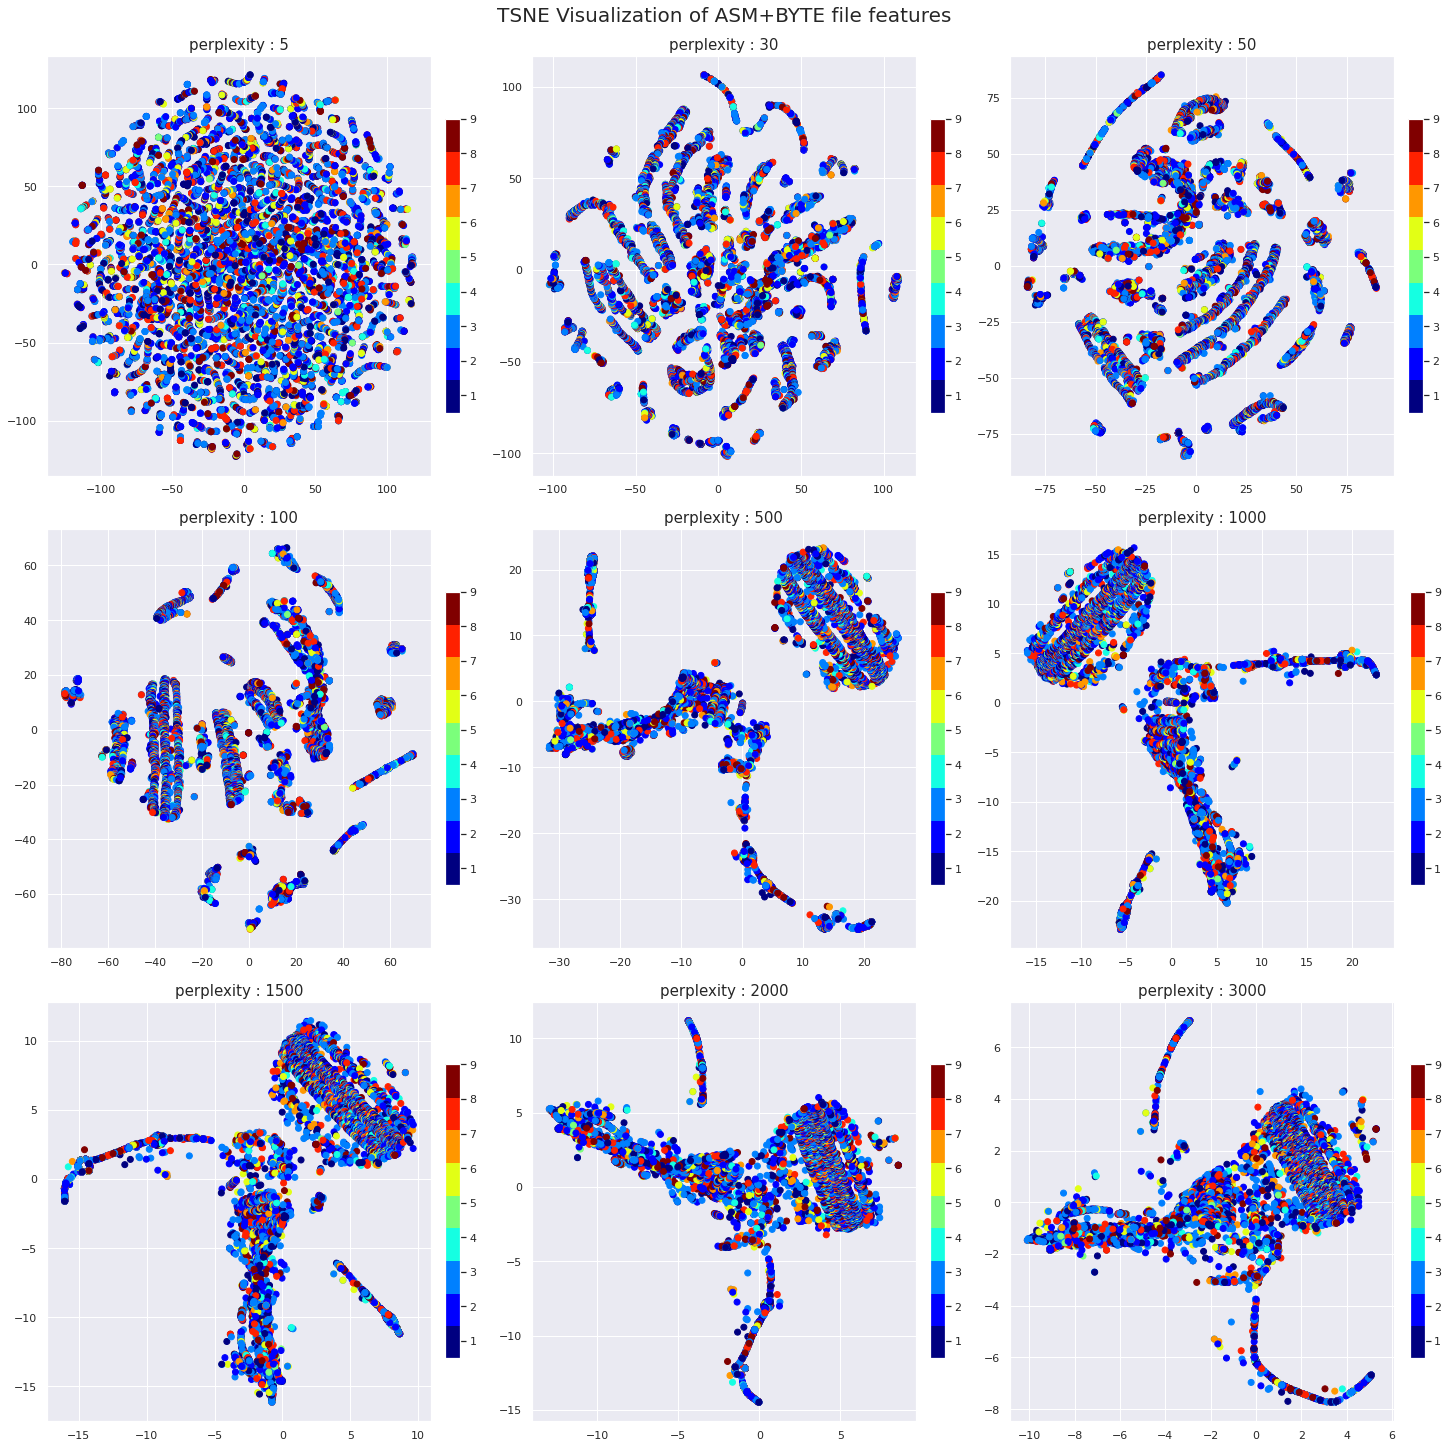

In [ ]:
perplex = [5, 30, 50, 100, 500, 1000, 1500, 2000, 3000]
fig, ax = plt.subplots(3,3, figsize=(20,20), constrained_layout=True)
ax = ax.flat
d = zip(ax, perplex)
fig.suptitle("TSNE Visualization of ASM+BYTE file features", fontsize=20)
for i,j in tqdm(d):
    xtsne=TSNE(perplexity=j)
    results=xtsne.fit_transform(result_x)
    vis_x = results[:, 0]
    vis_y = results[:, 1]
    im = i.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
    im.set_clim(0.5, 9)
    i.set_title(f"perplexity : {j}", fontsize=15)
    fig.colorbar(im, ax=i, shrink=0.7)
plt.show()

## Train and Test split

In [ ]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

### Random Forest Classifier on final features

100%|██████████| 7/7 [29:57<00:00, 256.79s/it]


log_loss for c =  10 is 5.920754876484751
log_loss for c =  50 is 5.966504060261218
log_loss for c =  100 is 5.983941065455877
log_loss for c =  500 is 5.984947576803618
log_loss for c =  1000 is 5.990557615029235
log_loss for c =  2000 is 5.991474012132678
log_loss for c =  3000 is 5.993263137309314


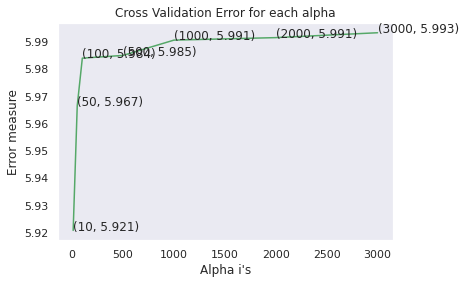

For values of best alpha =  10 The train log loss is: 0.018235436679825526
For values of best alpha =  10 The cross validation log loss is: 0.03933613420355843
For values of best alpha =  10 The test log loss is: 0.04477127090006044


In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_merge,y_train_merge)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

In [ ]:
rf_features = dict(zip(r_cfl.feature_names_in_, r_cfl.feature_importances_))

In [ ]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value#:~:text=%3E%3E%3E%20dict(sorted(x.items()%2C%20key%3Dlambda%20item%3A%20item%5B1%5D))
#sorting
rf_features = dict(sorted(rf_features.items(), key=lambda item: round(item[1],5), reverse=True))

In [ ]:
print(f'The number of features contributing in training the model: {list(rf_features.values()).index(0)}')

The number of features contributing in training the model: 1011


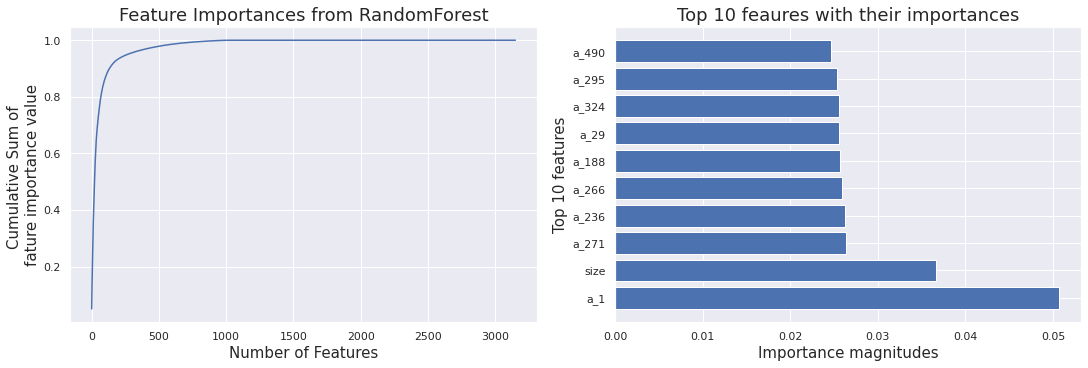

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
ax1.plot(np.cumsum(list(rf_features.values())))
ax1.set_title("Feature Importances from RandomForest", fontsize=18)
ax1.set_xlabel("Number of Features", fontsize=15)
ax1.set_ylabel("Cumulative Sum of \nfature importance value", fontsize=15)

ax2.barh(list(rf_features.keys())[:10], list(rf_features.values())[:10])
ax2.set_title("Top 10 feaures with their importances", fontsize=18)
ax2.set_xlabel("Importance magnitudes", fontsize=15)
ax2.set_ylabel("Top 10 features", fontsize=15)
plt.show()

<font color='maroon'><h3>From figure1 it is clear that only ~1000 features are contributing in training the model.</h3><font>

<font color='maroon'><h2>Creating dataset only with the top 1011 features obtained from random forest model.</h2></font>

In [ ]:
rf_features = X_train_merge[list(r_cfl.feature_names_in_)[:list(rf_features.values()).index(0)]]

In [ ]:
rf_features.to_csv('/content/drive/MyDrive/Colab Notebooks/rf_features.csv', index=False)
rf_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rf_features.csv')

In [ ]:
rf_features.head()

HEADER:    .text:  .Pav:   .idata:    .data:  .bss:   .rdata:  .edata:  \
0  0.096045  0.068086    0.0  0.001486  0.000630    0.0  0.004653      0.0   
1  0.107345  0.076648    0.0  0.003924  0.002416    0.0  0.000770      0.0   
2  0.096045  0.055980    0.0  0.005835  0.012578    0.0  0.078564      0.0   
3  0.107345  0.004703    0.0  0.000755  0.311344    0.0  0.000155      0.0   
4  0.101695  0.013086    0.0  0.001468  0.002512    0.0  0.000000      0.0   

     .rsrc:  .tls:  ...  b_152  b_153  b_154  b_155  b_156  b_157  b_158  \
0  0.000072    0.0  ...     50     32     48     52     32     48     48   
1  0.000072    0.0  ...     54     32     52     54     32     50     56   
2  0.000072    0.0  ...     56     32     52     69     32     55     52   
3  0.000000    0.0  ...     48     32     66     69     32     48     48   
4  0.000072    0.0  ...     65     32     48     48     32     56     65   

   b_159  b_160  b_161  
0     32     67     67  
1     32     48     48  
2     32     49     56  
3     32     48     48  
4     32     49     70  

[5 rows x 1011 columns]

### XgBoost Classifier on final features with best hyper parameters using Random search

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_merge = le.fit_transform(y_train_merge)

In [ ]:
x_cfl= x_cfl = XGBClassifier(subsample=1, n_estimators=200, max_depth=5, learning_rate=0.5, colsample_bytree=0.3)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
    
predict_y = sig_clf.predict_proba(X_train_merge)
print ("The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print("The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print("The test log loss is:",log_loss(y_test_merge, predict_y))

The train log loss is: 0.011032793015791525
The cross validation log loss is: 0.021873559501860203
The test log loss is: 0.018354240200592606


### Xgboost with important features from 'RandomForest' model

In [ ]:
x_cfl= x_cfl = XGBClassifier(subsample=1, n_estimators=200, max_depth=5, learning_rate=0.5, colsample_bytree=0.3)
x_cfl.fit(rf_features, y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(rf_features, y_train_merge)
    
predict_y = sig_clf.predict_proba(rf_features)
print ("The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge[rf_features.columns])
print("The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge[rf_features.columns])
print("The test log loss is:",log_loss(y_test_merge, predict_y))

The train log loss is: 0.010180953011207446
The cross validation log loss is: 0.022791237675798794
The test log loss is: 0.01758978986350312


In [1]:
from prettytable import PrettyTable
table1 = PrettyTable()
table1.title = 'Log-loss on BYTE files'
table1.field_names = ['Model', 'Test log-loss', 'CV log-loss']
table1.add_row(['random model', '2.498', '2.475'])
table1.add_row(['K-NN', '1.268', '1.263'])
table1.add_row(['Logistic Regression', '1.369', '1.371'])
table1.add_row(['Random Forest', '1.646', '1.642'])
table1.add_row(['Xgboost with hyperparameter tuning', '0.870', '0.890'])

table2 = PrettyTable()
table2.title = 'Log-loss on ASM files'
table2.field_names = ['Model', 'Test log-loss', 'CV log-loss']
table2.add_row(['K-NN', '0.202', '0.196'])
table2.add_row(['Logistic Regression', '1.671', '1.676'])
table2.add_row(['Random Forest', '0.033', '0.034'])
table2.add_row([f'Xgboost with hyperparameter tuning', '0.023', '0.031'])

table3 = PrettyTable()
table3.title = 'Log-loss on ASM+BYTE files'
table3.field_names = ['Model', 'Test log-loss', 'CV log-loss']
table3.add_row(['Random Forest', '0.029', '0.030'])
table3.add_row([f'Xgboost with hyperparameter tuning', '0.0183', '0.0218'])
table3.add_row([f'Xgboost with important features of RandomForest', '0.0176','0.0228'])

In [3]:
print('table-1')
print(table1)
print()
print('table-2')
print(table2)
print()
print('table-3')
print(table3)

table-1
+------------------------------------------------------------------+
|                      Log-loss on BYTE files                      |
+------------------------------------+---------------+-------------+
|               Model                | Test log-loss | CV log-loss |
+------------------------------------+---------------+-------------+
|            random model            |     2.498     |    2.475    |
|                K-NN                |     1.268     |    1.263    |
|        Logistic Regression         |     1.369     |    1.371    |
|           Random Forest            |     1.646     |    1.642    |
| Xgboost with hyperparameter tuning |     0.870     |    0.890    |
+------------------------------------+---------------+-------------+

table-2
+------------------------------------------------------------------+
|                      Log-loss on ASM files                       |
+------------------------------------+---------------+-------------+
|               M

## <font>Procedure</font>

> First separated byte and asm files and performed analysis separately.

<h4><b> Byte (unigrams+bigrams) files</b></h4>

> For each file computed both unigrams(256) and bigrams(65536+1) and stored in a csv and sparse matrix format. It resulted in 65793 features.

> Using truncated svd to reduce dimensionality of data, transformed the features into planes where ~94% of variance is preserved using 1500 components.

> Then performed classification using various models which resulted in the least log-loss of 0.870 uing byte features.

<h4><b> ASM(unigrams) files + pixels(ams, byte) files</b></h4>

> Computed unigrams of the top 50 most important words in all files.
 
> Then converted both asm and byte files into pixels and took the first 800 pixels as features.

> Performed classification by combining both unigrams and pixel features and obtained a least log-loss of <b>0.023</b>

<h4><b> ASM+Byte files(unigrams+bigrams+pixel intensities)</b></h4>

> Combined all the features i.e. unigrams, bigrams, pixel intensities.

> Performed classification using
><ol>
<li>Random forest: log-loss:- 0.029</li>
<li>Xgboost : log-loss:- 0.0183</li>
<li>Xgboost with important features from random forest: log-loss:- 0.0176
</ol>

> While performing classification task all the features are normalized where in an otherwise case log-loss found to be grown.

> The asm files unigram features along with pixel intensities found to be useful compared to the unigram and bigram features of bytefiles. 

<h2> References</h2>

- https://towardsdatascience.com/malware-classification-using-machine-learning-7c648fb1da79

- https://www.youtube.com/watch?v=VLQTRlLGz5Y&t=836s

- https://www.youtube.com/watch?v=fKl2JW_qrso
- https://www.youtube.com/watch?v=_1ZwkCY9wxk&t=329s
